In [5]:
!rm -rf /kaggle/working/*


=== Federated Round 1 ===
Client 1 | Loss: 0.5691 | Acc: 0.7823
Client 2 | Loss: 0.5691 | Acc: 0.7817
Client 3 | Loss: 0.5721 | Acc: 0.7805
Client 4 | Loss: 0.5685 | Acc: 0.7814
Client 5 | Loss: 0.5793 | Acc: 0.7792

=== Federated Round 2 ===
Client 1 | Loss: 0.3083 | Acc: 0.8752
Client 2 | Loss: 0.3059 | Acc: 0.8777
Client 3 | Loss: 0.3113 | Acc: 0.8745
Client 4 | Loss: 0.3035 | Acc: 0.8764
Client 5 | Loss: 0.3115 | Acc: 0.8729

=== Federated Round 3 ===
Client 1 | Loss: 0.2705 | Acc: 0.8910
Client 2 | Loss: 0.2703 | Acc: 0.8911
Client 3 | Loss: 0.2690 | Acc: 0.8923
Client 4 | Loss: 0.2670 | Acc: 0.8919
Client 5 | Loss: 0.2680 | Acc: 0.8918

=== Federated Round 4 ===
Client 1 | Loss: 0.2508 | Acc: 0.8976
Client 2 | Loss: 0.2535 | Acc: 0.8973
Client 3 | Loss: 0.2539 | Acc: 0.8982
Client 4 | Loss: 0.2499 | Acc: 0.8989
Client 5 | Loss: 0.2530 | Acc: 0.8976

=== Federated Round 5 ===
Client 1 | Loss: 0.2418 | Acc: 0.9012
Client 2 | Loss: 0.2449 | Acc: 0.8993
Client 3 | Loss: 0.2434 | Acc

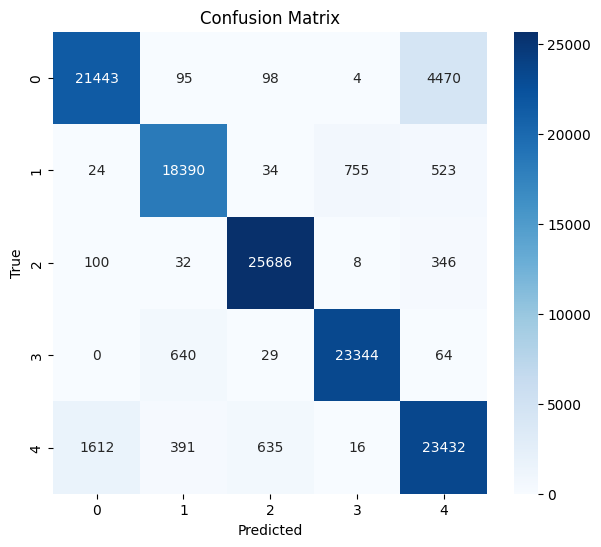

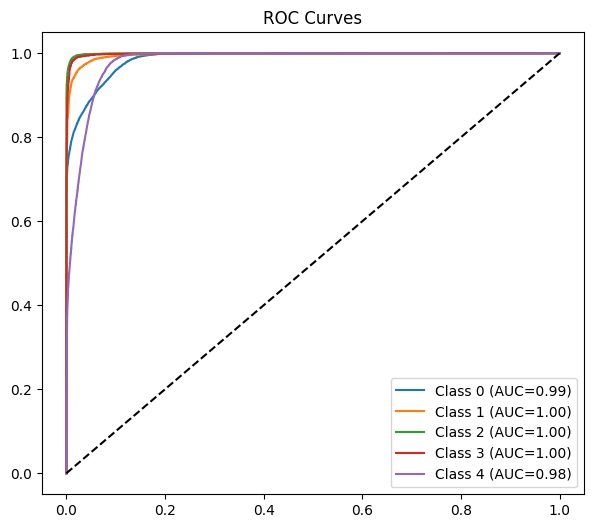


All results saved to: /kaggle/working/federated_results


In [6]:
# ============================================================
# Federated GCN for UAV Intrusion Detection
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc
)
from sklearn.neighbors import kneighbors_graph
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------
# CONFIGURATION
# ---------------------------
CSV_PATH = "/kaggle/input/uavids-2025/UAVIDS-2025.csv"
OUTPUT_DIR = "/kaggle/working/federated_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLIENTS = 5
ROUNDS = 20
LOCAL_EPOCHS = 2
BATCH_SIZE = 1024
K = 5
HIDDEN_DIM = 64

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# LOAD & PREPROCESS DATA
# ---------------------------
df = pd.read_csv(CSV_PATH)

label_col = next(c for c in df.columns if c.lower() in ["label","class","attack","type"])
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c.lower() not in ["id","flowid","index"]]

X_np = df[num_cols[:22]].fillna(0).values.astype(np.float32)
X_np = StandardScaler().fit_transform(X_np)

y_np = LabelEncoder().fit_transform(df[label_col].astype(str))
NUM_CLASSES = len(np.unique(y_np))

X = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

# ---------------------------
# GRAPH CONSTRUCTION (SPARSE)
# ---------------------------
adj = kneighbors_graph(X_np, K, mode="connectivity", include_self=True)
adj = sp.coo_matrix(adj)

edge_pairs = np.vstack([adj.row, adj.col])
edge_labels = y_np[edge_pairs[0]]

indices = torch.tensor(edge_pairs, dtype=torch.long)
values = torch.tensor(adj.data, dtype=torch.float32)

A_sparse = torch.sparse_coo_tensor(indices, values, adj.shape).to(DEVICE)

# ---------------------------
# EDGE SPLITS (FEDERATED)
# ---------------------------
all_edges = np.arange(edge_pairs.shape[1])
train_edges, test_edges = train_test_split(
    all_edges, test_size=0.2, stratify=edge_labels, random_state=42
)

client_splits = np.array_split(train_edges, NUM_CLIENTS)

def edge_loader(edge_idx, shuffle=True):
    src = torch.tensor(edge_pairs[0, edge_idx])
    dst = torch.tensor(edge_pairs[1, edge_idx])
    lbl = torch.tensor(edge_labels[edge_idx])
    return DataLoader(
        TensorDataset(src, dst, lbl),
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

# ---------------------------
# GCN MODEL
# ---------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_dim, out_dim) * 0.01)

    def forward(self, X, A):
        return torch.sparse.mm(A, X) @ self.W

class FederatedGCN(nn.Module):
    def __init__(self, in_dim, hidden, num_classes):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden)
        self.gcn2 = GCNLayer(hidden, hidden)
        self.fc1 = nn.Linear(hidden * 2, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward_edges(self, X, A, src, dst):
        h = F.relu(self.gcn1(X, A))
        h = F.relu(self.gcn2(h, A))
        e = torch.cat([h[src], h[dst]], dim=1)
        return self.fc2(F.relu(self.fc1(e)))

# ---------------------------
# LOCAL TRAINING
# ---------------------------
def local_train(model, loader):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    losses, preds_all, labels_all = [], [], []

    for _ in range(LOCAL_EPOCHS):
        for src, dst, lbl in loader:
            src, dst, lbl = src.to(DEVICE), dst.to(DEVICE), lbl.to(DEVICE)
            opt.zero_grad()
            out = model.forward_edges(X, A_sparse, src, dst)
            loss = loss_fn(out, lbl)
            loss.backward()
            opt.step()

            losses.append(loss.item())
            preds_all.extend(out.argmax(1).cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())

    return model.state_dict(), np.mean(losses), accuracy_score(labels_all, preds_all)

# ---------------------------
# FEDERATED AVERAGING
# ---------------------------
def fed_avg(states):
    avg = {}
    for k in states[0]:
        avg[k] = torch.mean(torch.stack([s[k] for s in states]), dim=0)
    return avg

# ---------------------------
# FEDERATED TRAINING
# ---------------------------
global_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

for rnd in range(1, ROUNDS + 1):
    print(f"\n=== Federated Round {rnd} ===")
    local_states = []

    for cid in range(NUM_CLIENTS):
        local_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())
        loader = edge_loader(client_splits[cid])
        state, loss, acc = local_train(local_model, loader)
        local_states.append(state)
        print(f"Client {cid+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

    global_model.load_state_dict(fed_avg(local_states))

# ---------------------------
# PER-CLIENT PER-ATTACK METRICS
# ---------------------------
global_model.eval()

for cid in range(NUM_CLIENTS):
    edges = client_splits[cid]
    src = torch.tensor(edge_pairs[0, edges]).to(DEVICE)
    dst = torch.tensor(edge_pairs[1, edges]).to(DEVICE)

    with torch.no_grad():
        out = global_model.forward_edges(X, A_sparse, src, dst)

    preds = out.argmax(1).cpu().numpy()
    true = edge_labels[edges]

    p, r, f, _ = precision_recall_fscore_support(true, preds, average=None, zero_division=0)

    df_metrics = pd.DataFrame({
        "Precision": p,
        "Recall": r,
        "F1-Score": f
    })

    df_metrics.to_csv(f"{OUTPUT_DIR}/client_{cid+1}_per_attack_metrics.csv",
                      index_label="Attack_Class")

# ---------------------------
# GLOBAL TEST EVALUATION
# ---------------------------
test_loader = edge_loader(test_edges, shuffle=False)

all_preds, all_true, all_probs = [], [], []

with torch.no_grad():
    for src, dst, lbl in test_loader:
        out = global_model.forward_edges(X, A_sparse, src.to(DEVICE), dst.to(DEVICE))
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_true.extend(lbl.numpy())
        all_probs.extend(torch.softmax(out, 1).cpu().numpy())

# ---------------------------
# CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.show()

# ---------------------------
# ROC CURVES
# ---------------------------
y_bin = label_binarize(all_true, classes=range(NUM_CLASSES))
all_probs = np.array(all_probs)

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curves")
plt.savefig(f"{OUTPUT_DIR}/roc_curves.png")
plt.show()

print("\nAll results saved to:", OUTPUT_DIR)


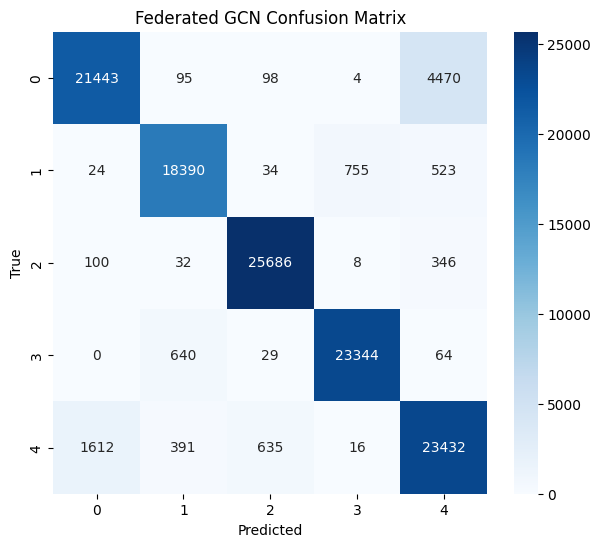

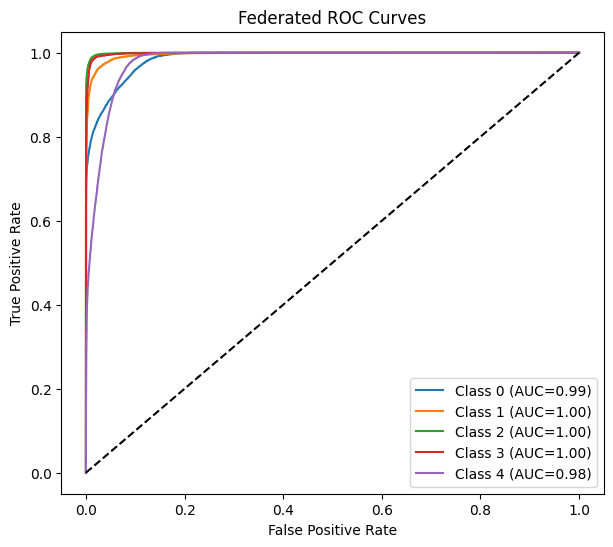

✅ All results saved as BOTH .png and .mat in:
/kaggle/working/federated_results


In [7]:
# ============================================================
# RESULTS EXPORT CELL (PNG + MAT)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ---------------------------
# 1. CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(all_true, all_preds)

# Save .mat
savemat(
    f"{OUTPUT_DIR}/confusion_matrix.mat",
    {
        "confusion_matrix": cm,
        "class_labels": np.arange(NUM_CLASSES)
    }
)

# Save .png
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Federated GCN Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------
# 2. ROC CURVES (PER CLASS)
# ---------------------------
y_bin = label_binarize(all_true, classes=np.arange(NUM_CLASSES))

roc_data = {}

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)

    roc_data[f"class_{i}"] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc
    }

    plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Federated ROC Curves")
plt.legend()
plt.savefig(f"{OUTPUT_DIR}/roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()

# Save ROC to .mat
savemat(
    f"{OUTPUT_DIR}/roc_curves.mat",
    roc_data
)

# ---------------------------
# 3. PER-CLIENT PER-ATTACK METRICS
# ---------------------------
# Assumes client CSVs already created earlier
# Convert them to .mat for MATLAB use

import glob
import pandas as pd

client_metric_files = glob.glob(f"{OUTPUT_DIR}/client_*_per_attack_metrics.csv")

client_metrics_mat = {}

for file in client_metric_files:
    client_id = os.path.basename(file).replace("_per_attack_metrics.csv","")
    df = pd.read_csv(file)
    client_metrics_mat[client_id] = df.values

savemat(
    f"{OUTPUT_DIR}/client_per_attack_metrics.mat",
    client_metrics_mat
)

# ---------------------------
# 4. GLOBAL SUMMARY METRICS
# ---------------------------
overall_accuracy = np.mean(np.array(all_true) == np.array(all_preds))

savemat(
    f"{OUTPUT_DIR}/global_summary.mat",
    {
        "overall_accuracy": overall_accuracy,
        "num_classes": NUM_CLASSES,
        "num_samples": len(all_true)
    }
)

print("✅ All results saved as BOTH .png and .mat in:")
print(OUTPUT_DIR)


**NON IID**

Label Distribution per Client (Non-IID):
Client 1: {np.int64(0): np.int64(48869), np.int64(2): np.int64(43688), np.int64(3): np.int64(5180)}
Client 2: {np.int64(3): np.int64(42260), np.int64(4): np.int64(55476)}
Client 3: {np.int64(0): np.int64(48869), np.int64(1): np.int64(36737), np.int64(2): np.int64(12132)}
Client 4: {np.int64(0): np.int64(6702), np.int64(1): np.int64(42167), np.int64(4): np.int64(48868)}
Client 5: {np.int64(2): np.int64(48868), np.int64(3): np.int64(48868)}

Round 1/30
 Client 1 | Loss: 0.2384 | Acc: 0.9293
 Client 2 | Loss: 0.2310 | Acc: 0.9252
 Client 3 | Loss: 0.2793 | Acc: 0.8972
 Client 4 | Loss: 0.3746 | Acc: 0.8738
 Client 5 | Loss: 0.2004 | Acc: 0.9455

Round 2/30
 Client 2 | Loss: 0.0477 | Acc: 0.9876
 Client 3 | Loss: 0.0617 | Acc: 0.9791
 Client 4 | Loss: 0.2068 | Acc: 0.9379
 Client 5 | Loss: 0.0105 | Acc: 0.9971

Round 6/30

Round 7/30

Round 8/30

Round 9/30

Round 10/30
 Client 1 | Loss: 0.0176 | Acc: 0.9940
 Client 2 | Loss: 0.0314 | Acc: 0.9909
 C

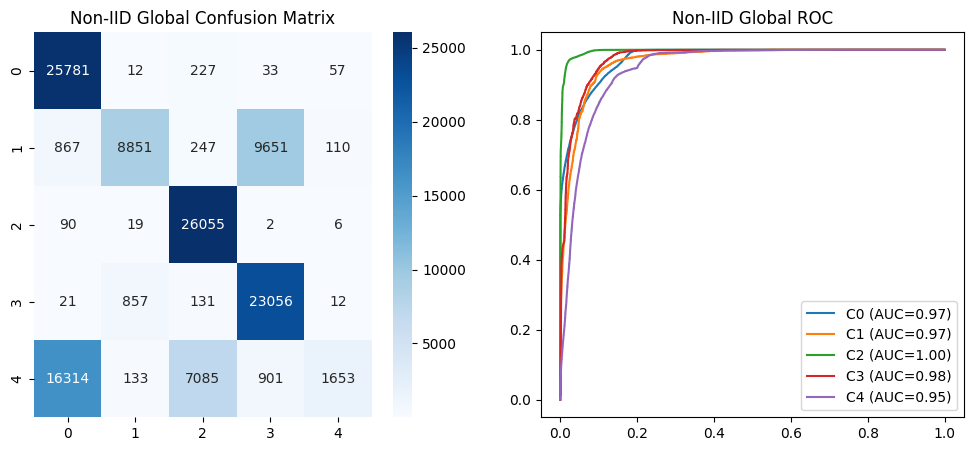


Training Complete. Global Accuracy: 0.6990


In [10]:
# ============================================================
# Federated GCN for UAV Intrusion Detection (Non-IID Version)
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc
)
from sklearn.neighbors import kneighbors_graph
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------
# CONFIGURATION
# ---------------------------
CSV_PATH = "/kaggle/input/uavids-2025/UAVIDS-2025.csv"
OUTPUT_DIR = "/kaggle/working/federated_results_non_iid"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLIENTS = 5
ROUNDS = 30           # Increased rounds for Non-IID convergence
LOCAL_EPOCHS = 3      # Slightly more local training per round
BATCH_SIZE = 1024
K = 5
HIDDEN_DIM = 64

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# LOAD & PREPROCESS DATA
# ---------------------------
df = pd.read_csv(CSV_PATH)
label_col = next(c for c in df.columns if c.lower() in ["label","class","attack","type"])
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c.lower() not in ["id","flowid","index"]]

X_np = df[num_cols[:22]].fillna(0).values.astype(np.float32)
X_np = StandardScaler().fit_transform(X_np)
y_np = LabelEncoder().fit_transform(df[label_col].astype(str))
NUM_CLASSES = len(np.unique(y_np))

X = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

# ---------------------------
# GRAPH CONSTRUCTION (SPARSE)
# ---------------------------
adj = kneighbors_graph(X_np, K, mode="connectivity", include_self=True)
adj = sp.coo_matrix(adj)
edge_pairs = np.vstack([adj.row, adj.col])
edge_labels = y_np[edge_pairs[0]]

indices = torch.tensor(edge_pairs, dtype=torch.long)
values = torch.tensor(adj.data, dtype=torch.float32)
A_sparse = torch.sparse_coo_tensor(indices, values, adj.shape).to(DEVICE)

# ---------------------------
# NON-IID EDGE SPLITS
# ---------------------------
all_edges = np.arange(edge_pairs.shape[1])
train_edges, test_edges = train_test_split(
    all_edges, test_size=0.2, stratify=edge_labels, random_state=42
)

def get_non_iid_splits(idx, labels, n_clients):
    """
    Partitions data such that each client receives a skewed subset 
    of labels (Non-IID distribution).
    """
    # Sort indices by label to group similar attacks together
    sorted_idx = idx[np.argsort(labels[idx])]
    
    # Split into double the number of clients (shards)
    shards = np.array_split(sorted_idx, n_clients * 2)
    np.random.shuffle(shards)
    
    # Assign two random shards to each client
    client_map = []
    for i in range(n_clients):
        client_data = np.concatenate([shards[i], shards[i + n_clients]])
        client_map.append(client_data)
    return client_map

client_splits = get_non_iid_splits(train_edges, edge_labels, NUM_CLIENTS)

# Print Label Distribution for Verification
print("Label Distribution per Client (Non-IID):")
for i in range(NUM_CLIENTS):
    unique, counts = np.unique(edge_labels[client_splits[i]], return_counts=True)
    print(f"Client {i+1}: {dict(zip(unique, counts))}")

def edge_loader(edge_idx, shuffle=True):
    src = torch.tensor(edge_pairs[0, edge_idx])
    dst = torch.tensor(edge_pairs[1, edge_idx])
    lbl = torch.tensor(edge_labels[edge_idx])
    return DataLoader(TensorDataset(src, dst, lbl), batch_size=BATCH_SIZE, shuffle=shuffle)

# ---------------------------
# GCN MODEL
# ---------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_dim, out_dim) * 0.01)
    def forward(self, X, A):
        return torch.sparse.mm(A, X) @ self.W

class FederatedGCN(nn.Module):
    def __init__(self, in_dim, hidden, num_classes):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden)
        self.gcn2 = GCNLayer(hidden, hidden)
        self.fc1 = nn.Linear(hidden * 2, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward_edges(self, X, A, src, dst):
        h = F.relu(self.gcn1(X, A))
        h = F.relu(self.gcn2(h, A))
        e = torch.cat([h[src], h[dst]], dim=1)
        return self.fc2(F.relu(self.fc1(e)))

# ---------------------------
# TRAINING FUNCTIONS
# ---------------------------
def local_train(model, loader):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=5e-4) # Slightly lower LR for stability
    loss_fn = nn.CrossEntropyLoss()
    losses, preds_all, labels_all = [], [], []

    for _ in range(LOCAL_EPOCHS):
        for src, dst, lbl in loader:
            src, dst, lbl = src.to(DEVICE), dst.to(DEVICE), lbl.to(DEVICE)
            opt.zero_grad()
            out = model.forward_edges(X, A_sparse, src, dst)
            loss = loss_fn(out, lbl)
            loss.backward()
            opt.step()
            losses.append(loss.item())
            preds_all.extend(out.argmax(1).cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())
    return model.state_dict(), np.mean(losses), accuracy_score(labels_all, preds_all)

def fed_avg(states):
    avg = {}
    for k in states[0]:
        avg[k] = torch.mean(torch.stack([s[k] for s in states]), dim=0)
    return avg

# ---------------------------
# FEDERATED LOOP
# ---------------------------
global_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

for rnd in range(1, ROUNDS + 1):
    local_states = []
    print(f"\nRound {rnd}/{ROUNDS}")
    
    for cid in range(NUM_CLIENTS):
        local_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())
        loader = edge_loader(client_splits[cid])
        state, loss, acc = local_train(local_model, loader)
        local_states.append(state)
        if rnd % 5 == 0 or rnd == 1:
            print(f" Client {cid+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

    global_model.load_state_dict(fed_avg(local_states))

# ---------------------------
# FINAL EVALUATION
# ---------------------------
global_model.eval()
test_loader = edge_loader(test_edges, shuffle=False)
all_preds, all_true, all_probs = [], [], []

with torch.no_grad():
    for src, dst, lbl in test_loader:
        out = global_model.forward_edges(X, A_sparse, src.to(DEVICE), dst.to(DEVICE))
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_true.extend(lbl.numpy())
        all_probs.extend(torch.softmax(out, 1).cpu().numpy())

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(all_true, all_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Non-IID Global Confusion Matrix")

plt.subplot(1, 2, 2)
y_bin = label_binarize(all_true, classes=range(NUM_CLASSES))
probs_arr = np.array(all_probs)
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs_arr[:, i])
    plt.plot(fpr, tpr, label=f"C{i} (AUC={auc(fpr,tpr):.2f})")
plt.legend()
plt.title("Non-IID Global ROC")
plt.savefig(f"{OUTPUT_DIR}/non_iid_results.png")
plt.show()

print(f"\nTraining Complete. Global Accuracy: {accuracy_score(all_true, all_preds):.4f}")

**This section is after the comments of Dr Sohail Abbas .....**

**FL-GCN**


=== Federated Round 1 ===
Client 1 | Loss: 0.5616 | Acc: 0.7784
Client 2 | Loss: 0.5646 | Acc: 0.7746
Client 3 | Loss: 0.5636 | Acc: 0.7776
Client 4 | Loss: 0.5702 | Acc: 0.7734
Client 5 | Loss: 0.5740 | Acc: 0.7761

=== Federated Round 2 ===
Client 1 | Loss: 0.2970 | Acc: 0.8799
Client 2 | Loss: 0.2953 | Acc: 0.8797
Client 3 | Loss: 0.2969 | Acc: 0.8799
Client 4 | Loss: 0.2908 | Acc: 0.8815
Client 5 | Loss: 0.3005 | Acc: 0.8789

=== Federated Round 3 ===
Client 1 | Loss: 0.2633 | Acc: 0.8927
Client 2 | Loss: 0.2650 | Acc: 0.8922
Client 3 | Loss: 0.2625 | Acc: 0.8932
Client 4 | Loss: 0.2591 | Acc: 0.8941
Client 5 | Loss: 0.2634 | Acc: 0.8928

=== Federated Round 4 ===
Client 1 | Loss: 0.2479 | Acc: 0.8985
Client 2 | Loss: 0.2512 | Acc: 0.8976
Client 3 | Loss: 0.2517 | Acc: 0.8978
Client 4 | Loss: 0.2485 | Acc: 0.8984
Client 5 | Loss: 0.2476 | Acc: 0.8991

=== Federated Round 5 ===
Client 1 | Loss: 0.2425 | Acc: 0.9002
Client 2 | Loss: 0.2433 | Acc: 0.8996
Client 3 | Loss: 0.2415 | Acc

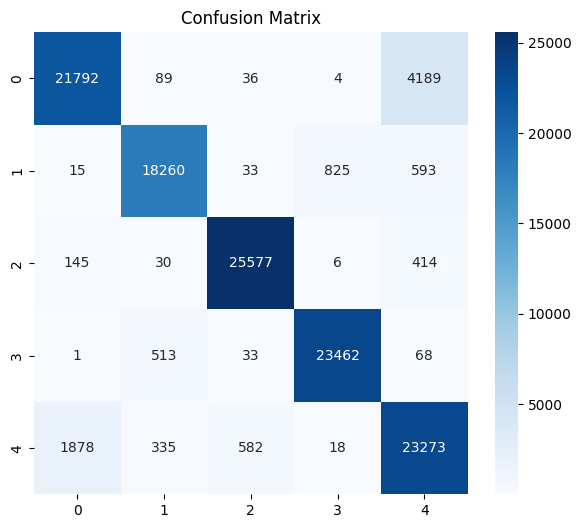

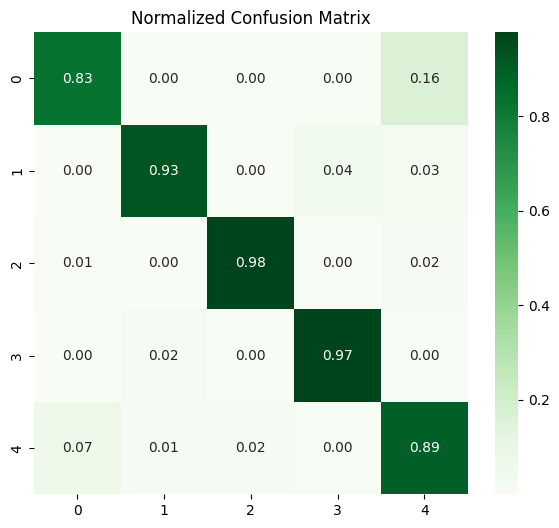

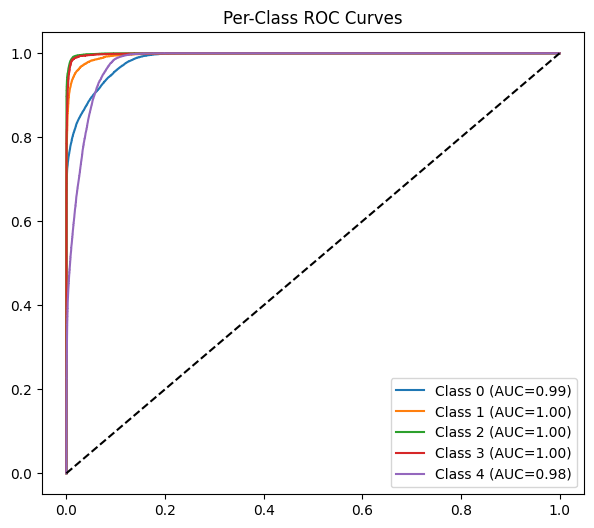


All results saved to: /kaggle/working/federated_results


In [1]:
# ============================================================
# Federated GCN for UAV Intrusion Detection (FULL EVALUATION)
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc,
    classification_report, matthews_corrcoef,
    cohen_kappa_score
)
from sklearn.neighbors import kneighbors_graph
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------
# CONFIGURATION
# ---------------------------
CSV_PATH = "/kaggle/input/uavids-2025/UAVIDS-2025.csv"
OUTPUT_DIR = "/kaggle/working/federated_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLIENTS = 5
ROUNDS = 20
LOCAL_EPOCHS = 2
BATCH_SIZE = 1024
K = 5
HIDDEN_DIM = 64

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# LOAD & PREPROCESS DATA
# ---------------------------
df = pd.read_csv(CSV_PATH)

label_col = next(c for c in df.columns if c.lower() in ["label","class","attack","type"])
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c.lower() not in ["id","flowid","index"]]

X_np = df[num_cols[:22]].fillna(0).values.astype(np.float32)
X_np = StandardScaler().fit_transform(X_np)

y_np = LabelEncoder().fit_transform(df[label_col].astype(str))
NUM_CLASSES = len(np.unique(y_np))

X = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

# ---------------------------
# GRAPH CONSTRUCTION
# ---------------------------
adj = kneighbors_graph(X_np, K, mode="connectivity", include_self=True)
adj = sp.coo_matrix(adj)

edge_pairs = np.vstack([adj.row, adj.col])
edge_labels = y_np[edge_pairs[0]]

indices = torch.tensor(edge_pairs, dtype=torch.long)
values = torch.tensor(adj.data, dtype=torch.float32)
A_sparse = torch.sparse_coo_tensor(indices, values, adj.shape).to(DEVICE)

# ---------------------------
# EDGE SPLITS (FEDERATED)
# ---------------------------
all_edges = np.arange(edge_pairs.shape[1])
train_edges, test_edges = train_test_split(
    all_edges, test_size=0.2, stratify=edge_labels, random_state=42
)

client_splits = np.array_split(train_edges, NUM_CLIENTS)

def edge_loader(edge_idx, shuffle=True):
    src = torch.tensor(edge_pairs[0, edge_idx])
    dst = torch.tensor(edge_pairs[1, edge_idx])
    lbl = torch.tensor(edge_labels[edge_idx])
    return DataLoader(
        TensorDataset(src, dst, lbl),
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

# ---------------------------
# GCN MODEL
# ---------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_dim, out_dim) * 0.01)

    def forward(self, X, A):
        return torch.sparse.mm(A, X) @ self.W

class FederatedGCN(nn.Module):
    def __init__(self, in_dim, hidden, num_classes):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden)
        self.gcn2 = GCNLayer(hidden, hidden)
        self.fc1 = nn.Linear(hidden * 2, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward_edges(self, X, A, src, dst):
        h = F.relu(self.gcn1(X, A))
        h = F.relu(self.gcn2(h, A))
        e = torch.cat([h[src], h[dst]], dim=1)
        return self.fc2(F.relu(self.fc1(e)))

# ---------------------------
# LOCAL TRAINING
# ---------------------------
def local_train(model, loader):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    losses, preds_all, labels_all = [], [], []

    for _ in range(LOCAL_EPOCHS):
        for src, dst, lbl in loader:
            src, dst, lbl = src.to(DEVICE), dst.to(DEVICE), lbl.to(DEVICE)
            opt.zero_grad()
            out = model.forward_edges(X, A_sparse, src, dst)
            loss = loss_fn(out, lbl)
            loss.backward()
            opt.step()

            losses.append(loss.item())
            preds_all.extend(out.argmax(1).cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    return model.state_dict(), np.mean(losses), acc

# ---------------------------
# FEDERATED AVERAGING
# ---------------------------
def fed_avg(states):
    avg = {}
    for k in states[0]:
        avg[k] = torch.mean(torch.stack([s[k] for s in states]), dim=0)
    return avg

# ---------------------------
# FEDERATED TRAINING
# ---------------------------
global_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

for rnd in range(1, ROUNDS + 1):
    print(f"\n=== Federated Round {rnd} ===")
    local_states = []

    for cid in range(NUM_CLIENTS):
        local_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())
        loader = edge_loader(client_splits[cid])
        state, loss, acc = local_train(local_model, loader)
        local_states.append(state)
        print(f"Client {cid+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

    global_model.load_state_dict(fed_avg(local_states))

# ---------------------------
# GLOBAL TEST EVALUATION
# ---------------------------
test_loader = edge_loader(test_edges, shuffle=False)

all_preds, all_true, all_probs = [], [], []

global_model.eval()
with torch.no_grad():
    for src, dst, lbl in test_loader:
        out = global_model.forward_edges(X, A_sparse, src.to(DEVICE), dst.to(DEVICE))
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_true.extend(lbl.numpy())
        all_probs.extend(torch.softmax(out, 1).cpu().numpy())

# ---------------------------
# GLOBAL METRICS
# ---------------------------
acc = accuracy_score(all_true, all_preds)

prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
    all_true, all_preds, average="macro", zero_division=0
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    all_true, all_preds, average="weighted", zero_division=0
)

mcc = matthews_corrcoef(all_true, all_preds)
kappa = cohen_kappa_score(all_true, all_preds)

print("\n=== Global Test Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {f1_m:.4f}")
print(f"Weighted F1: {f1_w:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Kappa: {kappa:.4f}")

# Save classification report
report = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
pd.DataFrame(report).transpose().to_csv(
    f"{OUTPUT_DIR}/global_classification_report.csv"
)

# ---------------------------
# CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(all_true, all_preds)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, None]

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.show()

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens")
plt.title("Normalized Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix_normalized.png")
plt.show()

# ---------------------------
# FPR & FNR
# ---------------------------
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

df_error = pd.DataFrame({
    "FPR": FP / (FP + TN + 1e-8),
    "FNR": FN / (FN + TP + 1e-8)
})
df_error.to_csv(f"{OUTPUT_DIR}/false_rates_per_class.csv")

# ---------------------------
# ROC CURVES
# ---------------------------
y_bin = label_binarize(all_true, classes=range(NUM_CLASSES))
all_probs = np.array(all_probs)

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("Per-Class ROC Curves")
plt.savefig(f"{OUTPUT_DIR}/roc_per_class.png")
plt.show()

print("\nAll results saved to:", OUTPUT_DIR)
